# Pytorch_Lightning + Wandb Starter
## About this notebook
*  This notebook is based on https://www.kaggle.com/chumajin/pytorch-neural-network-starter-detail 1)
* It incorporates pytorch lightning and also includes a very useful logger called wandb.

* pytorch lightning was made with reference to the following notebook. Thank you very much. Please also upvote this.
https://www.kaggle.com/phalanx/train-swin-t-pytorch-lightning 2) 

* If you are new to pytorch, I think it is better to use the notebook1).


---------------------------------------------------------------------------------------------------------

*  このノートブックは、https://www.kaggle.com/chumajin/pytorch-neural-network-starter-detail 1) をbaseに
* pytorch lightningを取り入れ、さらにとても便利なwandbというロガーを入れたものです。

* pytorch lightningは以下のnotebookを参考に作りました。ありがとうございます。こちらもupvoteお願いいたします。
https://www.kaggle.com/phalanx/train-swin-t-pytorch-lightning 2)

* pytorch初めての方は↑の1)のnotebookからの方がいいかなと思います。



# Add 1 Setting wandb

With wandb, you can see logs such as validation loss at a glance and compare with the previous experiment while turning machine learning. very convenient.

1) Register with wandb, sign in, and get api


2) Save the api as wandb_api in the tab Add-ons Secret at the top of this edit screen and check it.


(This feature is a mechanism that prevents others from seeing the contents of the variable on kaggle)


-------------日本語--------------
wandbを使うと機械学習を回している間に、validation lossなどのログが一目で見れたり、前の実験と比較できたりします。とても便利です。

1) wandbに登録して、signin後、apiを取得


2) このedit画面の上のタブAdd-ons Secret に wandb_apiという名前でapiを保存してチェックを入れる 


(この機能は、kaggle上で他の人に変数の中身が見れないような仕組みです)



In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

In [ ]:
!pip install python-box # 辞書型をつないでくれる　ex. model["A"]["B"]["C"] とかを model.A.B.C と表現可能に。

# Addition 2 config: It will read the dictionary type and save it as it is on wandb
追加2 config : wandbに飛ばすと辞書型を読んでそのまま保存してくれる

In [2]:
from box import Box

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule

#from glob import glob
import glob
import time

In [3]:
config = {'seed': 2021,
          
          'n_splits': 5,
          'epoch': 500,
          'trainer': {
              'gpus': 0, # gpuを使うときは1に
              'accumulate_grad_batches': 1,
              'progress_bar_refresh_rate': 1,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
          },
         
          'train_loader':{
              'batch_size': 256,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': 512,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          
          'optimizer':{
              'name': 'optim.Adam',
              'params':{
                  'lr': 1e-3
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 20,
                  'eta_min': 7.5e-5,
              }
          },
          'loss': 'nn.CrossEntropyLoss',
          
          "wandbprojectname":"Titanicmodel", # wandb save folder name & project name
          
                   
          "wandbversion": "v1", # save subfolder name & project version
          
          "comment":"PytorchLightning test from kaggle", # write comment what you want to keep a record on wandb
          
          "mode":"train",
          
          
}

config = Box(config)

In [ ]:
from pytorch_lightning.loggers.wandb import WandbLogger

try:
    wlogger = WandbLogger(project=config.wandbprojectname,version=config.wandbversion)
    # ハイパーパラメータ保存
    wlogger.log_hyperparams(config)

except:
    wlogger = TensorBoardLogger(config.wandbprojectname)

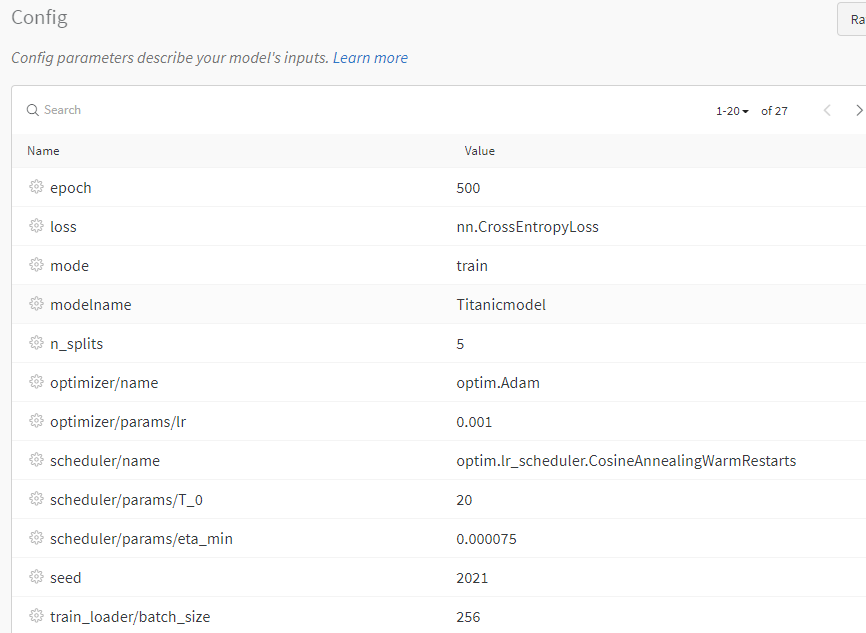

# Below, it is the same as the last time until the Dataset is created

以下、Dataset作成までは前回と同じ

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

import gc

import random

import transformers
import warnings
warnings.simplefilter('ignore')

#scaler = torch.cuda.amp.GradScaler() # GPUでの高速化。

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cpuがgpuかを自動判断
device

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 0. Confirming the train/test data : データの確認


In [ ]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df

In [ ]:
test = pd.read_csv("../input/titanic/test.csv")
test

## About data
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

#########日本語#################

survival	生死	0 = 死亡, 1 = 生存
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	性別	
Age	年齢	
sibsp	# of siblings / 親族の数	
parch	# of parents / 子供の数	
ticket	Ticket number　チケットナンバー	
fare	Passenger fare	運賃
cabin	Cabin number	部屋の番号
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton　乗船した場所


In [ ]:
df.info()

#### There are 891 rows. There are NaN data in Age, Cabin, Embarked.
#### 全部で891行あって、Age,Cabin,Embarkedにはnullデータはないが、NaNデータがありそう。

In [ ]:
df.columns

In [ ]:
for col in df.columns:
    print(str(col) + ":" + str(len(df[col].unique())))

# 1. Handling of NaN values : 欠損値の処理
### 1.1 filling an mean value. : 平均値で埋める

In [ ]:
df["Age"]

In [ ]:
# In order to get the average value, dropna is used to remove all but Nan data.
# 平均値を出すために、dropnaでNanデータ以外を抜きます。
df["Age"].dropna()

In [ ]:
dmean = df["Age"].dropna().mean()
dmean

In [ ]:
# filling an mean value. : 平均値で埋める

df["Age"] = df["Age"].fillna(dmean)

In [ ]:
df

In [ ]:
test["Age"] = test["Age"].fillna(dmean)

# 2 label encoding
#### Automatically convert strings to numbers. Since there is a significant difference such as 0 and 1, Sex is divided in this way.
#### 文字列を数字に自動変換. 0と1など有意差があるため、このやり方で性別を分けています。

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()
le.fit(df["Sex"])
df["Sex"] = le.transform(df["Sex"])
test["Sex"] = le.transform(test["Sex"])

In [ ]:
df

# 3. One-hot encoding
#### Automatically convert strings to numbers line by line. 
#### There are four Embarked places including NaN, but since no significant difference can be considered, divide them in parallel.
#### 文字列を行ごとに数字に自動変換。EmbarkedはNaNを入れて4つあるが、有意差が考えられないので、並列に分けます。

In [ ]:
# firstly, combining df and test. Combine vertically with axis = 0.
# トレインデータとテストデータを結合します。axis = 0 で縦に結合。

dfall = pd.concat([df,test],axis=0)
dfall

In [ ]:
# one-hot encoding using pd.get_dummies. NaN can also be separated by dummy_na = True.
# get_dummiesを使って、one-hot encodingします。dummy_na=TrueでNaNも分けることが可能。

dfall2 = pd.get_dummies(dfall["Embarked"],dummy_na=True)
dfall2

In [ ]:
# Combine horizontally with axis = 1.
# axis = 1 で横に結合。

dfall = pd.concat([dfall,dfall2],axis=1)
dfall

In [ ]:
# Separate the train data and test data and restore them.
# トレインデータとテストデータに分離して元に戻します。

train = dfall.iloc[:len(df),:]
test = dfall.iloc[len(df):,:]

In [ ]:
train

In [ ]:
test

# 4. Kfold
#### Prepare training data and verification data in 5 combinations.
#### 訓練データと検証データを5つの組み合わせで準備する。

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["Survived"])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', "Survived"]).size())

In [ ]:
folds

# 5.Neural Network using **pytorch-lightning**

# 5.1 Defining features and target
##     特徴量とラベル(ターゲット)を定義します

In [ ]:
# defining the feature columns and the target

FEATURES = ["Pclass","Sex","Age","SibSp","Parch","C","Q","S",np.nan]
TARGET = "Survived"

# 5.2 Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
Normarizescaler = StandardScaler()
Normarizescaler.fit(np.array(train[FEATURES]))

In [ ]:
class PytorchDataset(Dataset):

    def __init__(self,df):
        # for test data, In test data, it's easier to fill it with something on purpose.
        # テストデータも読み込めるようにわざと9999で埋めています。

        if "Survived" not in df.columns:
            df["Survived"] = 9999

        self.df = df

        self.train_X = np.array(self.df[FEATURES])
        self.train_Y = np.array(self.df[TARGET])

        self.train_X = Normarizescaler.transform(self.train_X)

        self.train_X = torch.from_numpy(self.train_X).float()
        self.train_Y = torch.from_numpy(self.train_Y).long() # long : int64

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        return self.train_X[idx],self.train_Y[idx]

# 5.3 **Pytorch Lightning**  DataModule 

In [ ]:
class PytorchDataModule(LightningDataModule):
    def __init__(self, train_df, val_df, cfg,):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

    def __create_dataset(self,train=True):
        if train:
            ret = PytorchDataset(self._train_df)
        else:
            ret = PytorchDataset(self._val_df)
        return ret

    def train_dataloader(self):
        dataset = self.__create_dataset(train=True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(train=False)
        return DataLoader(dataset, **self._cfg.val_loader)


In [ ]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed) # これだけで初期化完了

# 5.4 **Pytorch Lightning** Modeling

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
class Net(pl.LightningModule):
    def __init__(self,cfg,val_losses=None):
        super().__init__()

        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(self.cfg.loss)()
        self.save_hyperparameters(cfg)
        self.val_losses = val_losses

        self.t=time.time()
        self.steps_per_epoch = len(datamodule.train_dataloader())
        self.step = 0
        self.epoch = 0

    def __build_model(self):
        self.fc1 = nn.Linear(len(FEATURES),512) #input number and middle layer fc1
        self.fc2 = nn.Linear(512,256) # middle layer fc2
        self.fc3 = nn.Linear(256,2) # output

    def forward(self,x):
        x= F.relu(self.fc1(x)) # Put the relu function after fc1
        x= F.relu(self.fc2(x)) # Put the relu function after fc2
        x = self.fc3(x) # fc3
        return x

    def training_step(self, batch, batch_idx): # for a in train_dataloaderの1個分
        loss, pred, labels = self.__share_step(batch, "train")
        self.step +=1
        print ("Step [{}/{}] Loss: {:.3f} Time: {:.1f} Epoch:[{}/{}]"
                           .format(self.step, self.steps_per_epoch, loss, time.time()-self.t,self.epoch,self.cfg.epoch),end='\r',flush=True)
        return {"loss":loss, "pred":pred, "labels":labels}

    def validation_step(self, batch, batch_idx):
        loss,pred,labels = self.__share_step(batch,"val")
        self.log("valid_loss",loss) # wanbdに飛ばしてくれる
        return {"pred":pred,"labels":labels}

    def __share_step(self, batch, mode):
        data, labels = batch
        logits = self.forward(data).squeeze(1)
        loss = self._criterion(logits, labels)
        labels = labels.detach().cpu()
        return loss, logits, labels

    def training_epoch_end(self,outputs):
        self.__share_epoch_end(outputs, "train")

    def validation_epoch_end(self,outputs):
        self.__share_epoch_end(outputs, "val")

    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []

        for out in outputs:
            pred,label = out["pred"],out["labels"]
            preds.append(pred)
            labels.append(label)

        preds = torch.cat(preds)
        labels = torch.cat(labels)

        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        preds = [s.argmax() for s in preds]

        metrics = accuracy_score(labels,preds)

        self.log(f"{mode}_score",metrics)
        if mode=="val":
            self.val_losses.append(metrics)
            self.epoch +=1
            self.step = 0

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(self.parameters(),**self.cfg.optimizer.params)

        scheduler = eval(self.cfg.scheduler.name)(optimizer,**self.cfg.scheduler.params)
        return [optimizer], [scheduler]


# 5.5 Inference function to make out of fold (my original)

In [ ]:
def inference(dataloader):
    
    preds = []
    with torch.no_grad():
        
        for a in dataloader:
            
            a = a[0].to(device)
            logits = model(a).squeeze(1)
            #pred = logits.sigmoid().detach().cpu() 
            preds.append(logits)
            
        preds = np.concatenate(preds)
        
        return preds

In [ ]:
config

In [ ]:
config.trainer.progress_bar_refresh_rate = 0 # progress barを表示しない

# 6. Main

In [ ]:
if config.mode == "train":
    
    allscores = []
    allvaliddf = pd.DataFrame()
    

    for fold in range(config.n_splits):
        
        print(f"fold{fold}-----------start")
        
        seed_everything(config.seed)
        
        scores = []       
        

        train_df = folds[folds["fold"] != fold].reset_index(drop=True)
        val_df = folds[folds["fold"] == fold].reset_index(drop=True)

        datamodule = PytorchDataModule(train_df,val_df,config)

        model = Net(config,scores)

        earystopping = EarlyStopping(monitor="val_score",mode="max",patience = 100)

        lr_monitor = callbacks.LearningRateMonitor()

        loss_checkpoint = callbacks.ModelCheckpoint(

        filename = f"best_score{fold}",
            monitor = "val_score",
            save_top_k=1,
            mode="max",
            save_last=False,

        )

        #logger = TensorBoardLogger(config.model.name)

        trainer = pl.Trainer(

            logger = wlogger, # ここにwandbのログ
            max_epochs = config.epoch,
            callbacks = [lr_monitor,loss_checkpoint,earystopping],
            **config.trainer,    

        )

        trainer.fit(model,datamodule=datamodule)
        
        
        ## valscore ##
        
        print(f"fold{fold} : valscore is {np.max(scores)}")
        
        
        allscores.append(np.max(scores))
        
        
        modelpath = f"./{config.wandbprojectname}/{config.wandbversion}/checkpoints/best_score{fold}.ckpt"
        
            
        tmp = torch.load(modelpath)
        model.load_state_dict(tmp["state_dict"])
        model = model.to(device).eval()
        
        oofpreds = inference(datamodule.val_dataloader())
        
        oofpreds = [s.argmax() for s in oofpreds]
        
        val_df["preds"] = oofpreds
        
        allvaliddf = pd.concat([allvaliddf,val_df])
        
        


In [ ]:
try:
    wandb.finish()
except:
    pass

In [ ]:
allscores

In [ ]:
np.mean(allscores)

In [ ]:
allvaliddf

In [ ]:
allvaliddf = allvaliddf.sort_values("PassengerId").reset_index(drop=True)
allvaliddf.to_pickle("allvaliddf.pkl")

In [ ]:
accuracy_score(allvaliddf["Survived"],allvaliddf["preds"])

# 7. inference

In [ ]:
test

In [ ]:
datamodule2 = PytorchDataModule(train,test,config)

In [ ]:
pthes = glob.glob(f"./{config.wandbprojectname}/{config.wandbversion}/checkpoints/*.ckpt")

In [ ]:
model = Net(config) 

allpreds = []

for pth in tqdm(pthes):
    
    preds = []

    
    tmp = torch.load(pth)
    model.load_state_dict(tmp["state_dict"])
    model = model.to(device).eval()
    
    with torch.no_grad():
        
        for a,b in datamodule2.val_dataloader():
            
            a = a.to(device)
            logits = model(a).squeeze(1)
            pred = logits.sigmoid().detach().cpu() 
            preds.append(pred)
            
        preds = np.concatenate(preds)
        allpreds.append(preds)


In [ ]:
allpreds = np.mean(allpreds,axis=0)

In [ ]:
allpreds = [s.argmax() for s in allpreds]

In [ ]:
submission = pd.read_csv("../input/titanic/gender_submission.csv")
submission

In [ ]:
submission["Survived"] = allpreds

In [ ]:
submission

In [ ]:
submission.to_csv("submission.csv",index=False)